In [ ]:
import os 
import openai as model
import gradio
import hopsworks
import pandas as pd

project = hopsworks.login()

In [ ]:
org_id = ""
model.api_key = ""

In [2]:
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


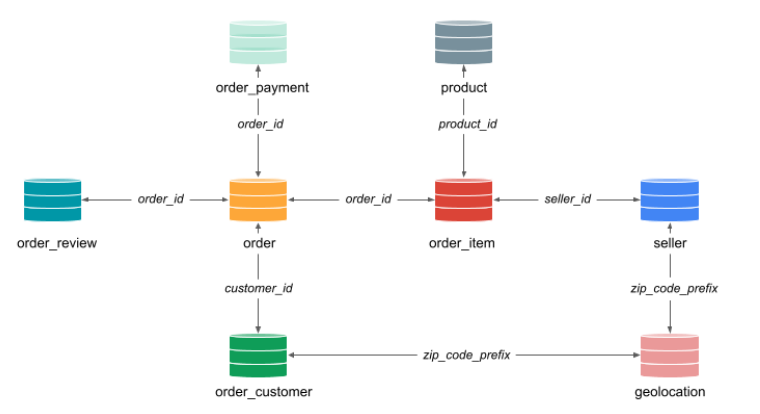

In [3]:
feature_view = fs.get_feature_view("product_orders", version=1)

df = feature_view.get_feature_vector(entry={"order_id" : "d7bd9020e0a2758aef0994ea533ee928", 
                                            "order_item_id": 1, 
                                            "product_id":"9ce4603565c839785b24a7e95e28f4eb"}, 
                                     allow_missing=True, 
                                     return_type="pandas")
df.to_string()
df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,freight_value,product_category_name,product_name_len,product_description_len,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,d7bd9020e0a2758aef0994ea533ee928,1,9ce4603565c839785b24a7e95e28f4eb,59fb871bf6f4522a87ba567b42dafecf,2017-05-11 10:55:17,26.09,cool_stuff,40.0,1516.0,2.0,800.0,22.0,15.0,27.0


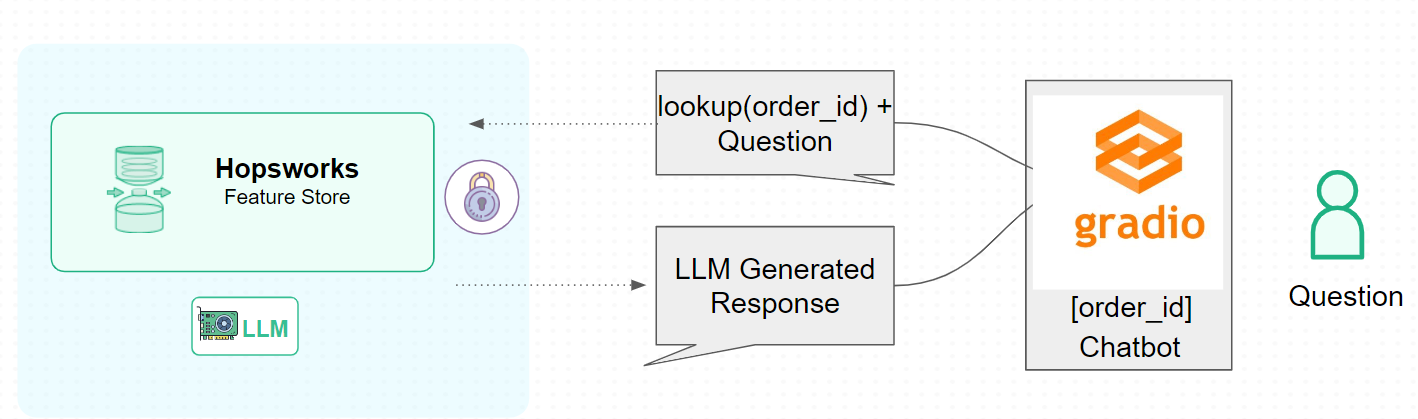

In [ ]:
prefix = df.to_string()

prompt = "Hi Fabio. What's on your mind today?"
def api_calling(prompt):
    completions = model.Completion.create( 
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5, 
    ) 
    message = completions.choices[0].text
    return message 


def message_and_history(input, history):
    history = history or []
    s = list(sum(history, ())) 
    s.append(input) 
    inp = ' '.join(s)
    template = """The following is a table with the first row containing column names and the second row containing column values. 
    The table represents my order of a product. The details of my order are in the 2nd row. \n"""
    inp = template + prefix + "\n" + inp
    print(inp)
    output = api_calling(inp) 
    history.append((input, output)) 
    return history, history 

block = gradio.Blocks(theme=gradio.themes.Monochrome()) 
with block: 
    gradio.Markdown("""<h1><center> 
    Hopsworks RAG ChatBot</center></h1> 
    """) 
    chatbot = gradio.Chatbot() 
    message = gradio.Textbox(placeholder=prompt) 
    state = gradio.State() 
    submit = gradio.Button("SEND") 
    submit.click(message_and_history,
                 inputs=[message, state],
                 outputs=[chatbot, state]) 
block.launch(debug = True, share=True)

        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        


Running on local URL:  http://127.0.0.1:7860
2023-10-30 17:48:12,338 INFO: Found credentials in shared credentials file: ~/.aws/credentials


Running on public URL: https://31bc038603ec6d5b0f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


The following is a table with the first row containing column names and the second row containing column values. 
    The table represents my order of a product. The details of my order are in the 2nd row. 
   Unnamed: 0                          order_id  order_item_id                        product_id                         seller_id  shipping_limit_date  freight_value product_category_name  product_name_len  product_description_len  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm
0           0  d7bd9020e0a2758aef0994ea533ee928              1  9ce4603565c839785b24a7e95e28f4eb  59fb871bf6f4522a87ba567b42dafecf  2017-05-11 10:55:17          26.09            cool_stuff              40.0                   1516.0                 2.0             800.0               22.0               15.0              27.0
What's included in my order?
The following is a table with the first row containing column names and the second row containing column values.